<a href="https://colab.research.google.com/github/polis-community/red-dwarf/blob/main/docs/notebooks/untested/tabpfn-experiment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%pip install --quiet red-dwarf[all]@git+https://github.com/polis-community/red-dwarf.git@main
%pip install --quiet tabpfn tabpfn-extensions[interpretability]

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 647.5/647.5 kB 22.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.1/116.1 kB 9.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 161.7/161.7 kB 14.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.4/61.4 kB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 69.4/69.4 kB 6.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 128.9/128.9 kB 9.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 293.3/293.3 kB 17.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 101.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 94.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━

### In order to get the fastest predictions you need to enable GPUs for the notebook:
* Navigate to Edit→Notebook Settings
* select the available GPU from the Hardware Accelerator drop-down

Time estimates:
- GPU: ~15 seconds
- CPU: ~20 minutes
- TPU: 10 minites

In [2]:
from reddwarf.data_loader import Loader
from reddwarf.implementations.base import run_pipeline
import numpy as np


In [2]:
from tabpfn_extensions import interpretability
from tabpfn import TabPFNClassifier

### What are your feelings on President Oprah 2020?
- Report: https://pol.is/report/r68fknmmmyhdpi3sh4ctc
- Conversation: https://pol.is/3ntrtcehas

In [3]:
# Initialize and load data
POLIS_REPORT_ID="r68fknmmmyhdpi3sh4ctc" # Oprah
loader = Loader(report_id=POLIS_REPORT_ID, data_source="csv_export")
loader.load_api_data_conversation()
print()
print(loader.conversation_data["topic"])
print(f"https://pol.is/{loader.conversation_id}")
print(f"https://pol.is/report/{loader.report_id}")

loader.load_api_data_math()
# Generate vote matrix and run clustering
result = run_pipeline(
    votes=loader.votes_data,
    reducer="pca",
    clusterer="kmeans",
    mod_out_statement_ids=loader.math_data["mod-out"],
    keep_participant_ids=loader.math_data["in-conv"],
)
clusterable_participants_df = result.participants_df[result.participants_df["cluster_id"].notnull()]
cluster_labels = clusterable_participants_df["cluster_id"].values

/usr/local/lib/python3.11/dist-packages/reddwarf/data_loader.py:130: UserWarning: CSV import is missing is_meta field. Attempting to load comments data from API instead...
  warnings.warn("CSV import is missing is_meta field. Attempting to load comments data from API instead...")



What are your feelings on President Oprah 2020?
https://pol.is/3ntrtcehas
https://pol.is/report/r68fknmmmyhdpi3sh4ctc


In [46]:
# Get feature names
feature_names = np.array([f"Statement_{i}" for i in result.raw_vote_matrix.index])

# Choose a specific cluster to analyze (e.g., cluster 0)
target_cluster = 0
y = (cluster_labels == target_cluster).astype(int)

# Split data
X = result.raw_vote_matrix.values
n_train = len(X) // 2
X_train, X_test = X[:n_train], X[n_train:]
y_train, y_test = y[:n_train], y[n_train:]

# Train model to predict cluster membership
clf = TabPFNClassifier()
clf.fit(X_train, y_train)

TabPFNClassifier()

In [47]:
# Calculate SHAP values for cluster membership prediction (this is what will take longer)
n_samples = 50
shap_values = interpretability.shap.get_shap_values(
    estimator=clf,
    test_x=X_test[:n_samples],
    attribute_names=feature_names,
    algorithm="permutation",
)

PermutationExplainer explainer: 51it [00:57,  1.36s/it]


In [48]:
# Save fitted model to drive
SAVE_MODEL = False # doesn't work yet
if SAVE_MODEL:
    from tabpfn.model.loading import (
        load_fitted_tabpfn_model,
        save_fitted_tabpfn_model,
    )
    from google.colab import drive
    drive.mount('/content/drive')

    save_fitted_tabpfn_model(clf, f"/content/drive/MyDrive/tabpfn/polis-{POLIS_REPORT_ID}-model.tabpfn_fit")

    # Later or on a CPU-only machine
    clf_cpu = load_fitted_tabpfn_model(f"/content/drive/MyDrive/tabpfn/polis-{POLIS_REPORT_ID}-model.tabpfn_fit", device="cpu")

Computing shap values for the first class (index 0).


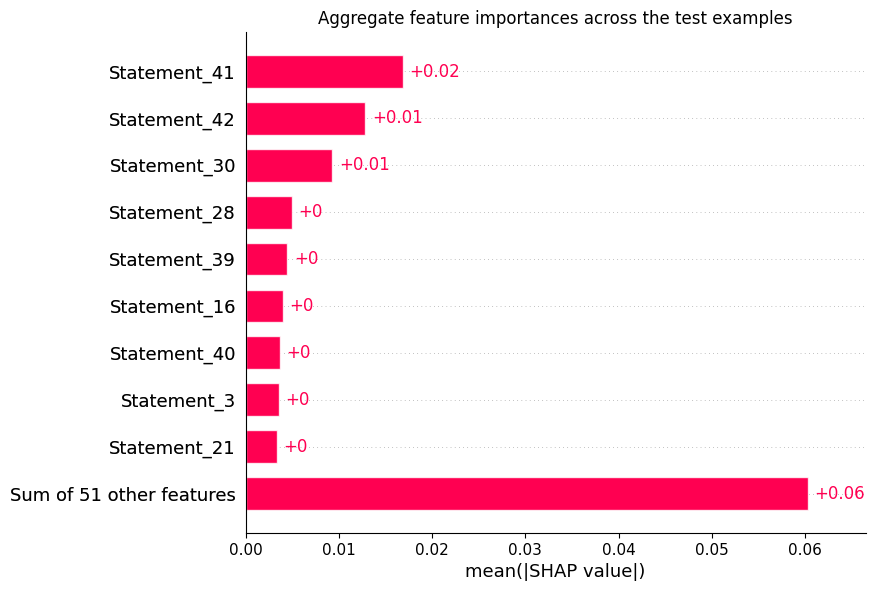

/usr/local/lib/python3.11/dist-packages/tabpfn_extensions/interpretability/shap.py:60: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values=shap_values, show=False)


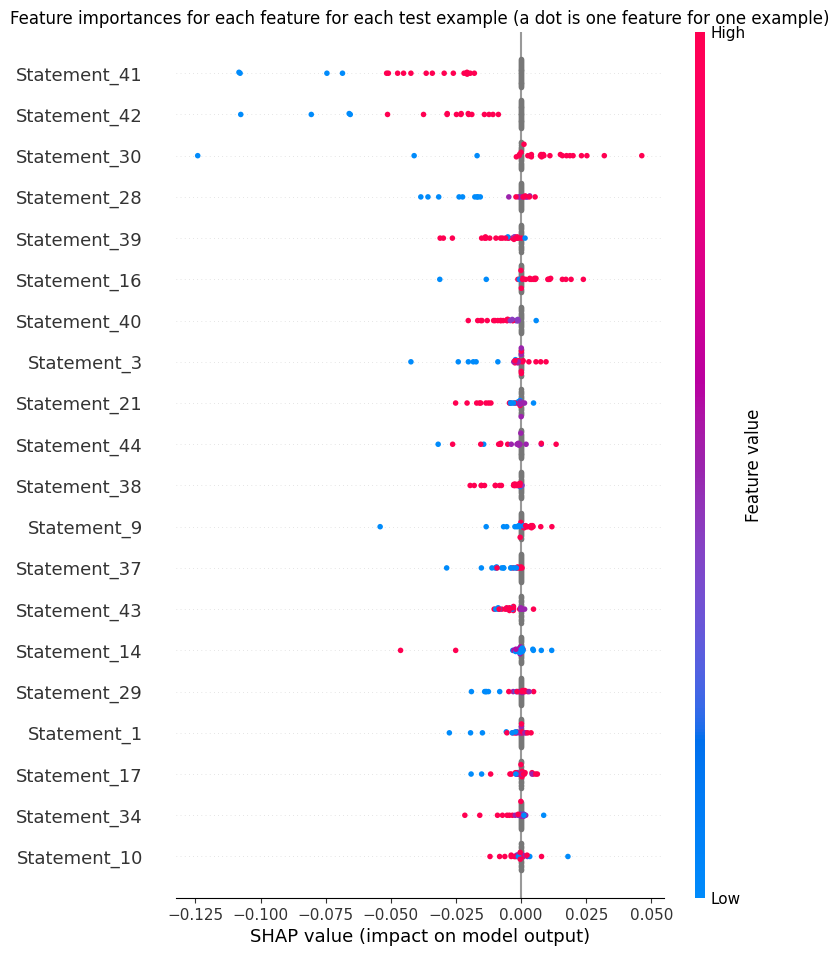

Now we analyze the strongest feature interactions of the most important feature, namely the feature "41".


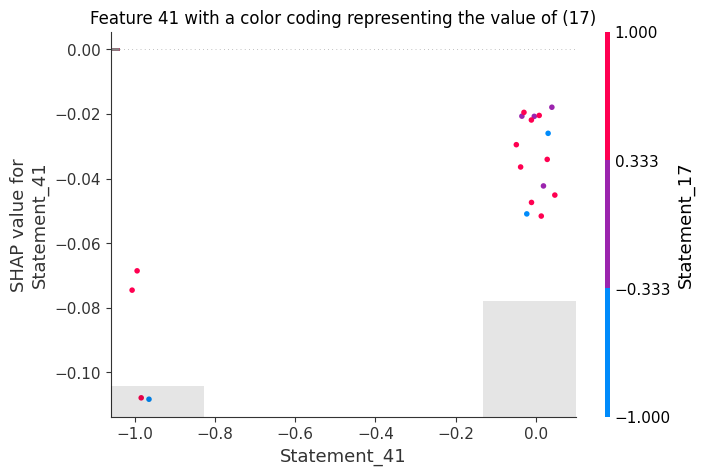

In [49]:
# Create visualization
fig = interpretability.shap.plot_shap(shap_values)

In [50]:
import numpy as np

mean_abs_shap = np.abs(shap_values.values).mean(axis=(0, 2))
sorted_indices = np.argsort(mean_abs_shap)[::-1]

try:
    feature_names = shap_values.feature_names
except AttributeError:
    feature_names = attribute_names  # from your original get_shap_values() call

top_features = [feature_names[i] for i in sorted_indices]

top_k = 5
# Confirm lists are same
print(sorted_indices[:10])
for rank, name in enumerate(top_features[:top_k], 1):
    print(f"{rank}. {name} (mean |SHAP| = {mean_abs_shap[sorted_indices[rank - 1]]:.4f})")

[41 42 30 28 39 16 40  3 21 44]
1. Statement_41 (mean |SHAP| = 0.0169)
2. Statement_42 (mean |SHAP| = 0.0128)
3. Statement_30 (mean |SHAP| = 0.0093)
4. Statement_28 (mean |SHAP| = 0.0050)
5. Statement_39 (mean |SHAP| = 0.0045)


In [51]:
def print_statement(index):
  statement = [c for c in loader.comments_data if c["statement_id"] == index][0]
  print(f"{statement['statement_id']}: {statement['txt']}")

for tid in sorted_indices[:top_k]:
  print_statement(int(tid))

41: She could be more impactful in areas outside of daily politics.
42: Clear
30: A candidate should be electable and appeal to as many citizens as possible. Her accomplishments aside,Oprah may be too polarizing a figure.
28: Oprah has supported "experts" like Dr. Phil and Dr. Oz that have hawked snake oil products. Not confident she'd pick better experts as potus
39: Other women, and other WOC, are more qualified than Oprah. Her voice is important, but she does not have the necessary experience.


### Attribution
- Code: https://github.com/ThenWho
- GPU tip: https://colab.research.google.com/drive/1SHa43VuHASLjevzO7y3-wPCxHY18-2H6?usp=sharing#scrollTo=pNaA6HvGoxsz